###  Capstone Module 23: Diabetic Retinopathy EDA Notebook
Author: Murli Satagopan

#### Step 1 Load the data set, check for missing values and plot the class distribution

Shape of dataset: (2930, 2)
Columns: Index(['id_code', 'diagnosis'], dtype='object')
Sample rows:
        id_code  diagnosis
0  1ae8c165fd53          2
1  1b329a127307          1
2  1b32e1d775ea          4
3  1b3647865779          0
4  1b398c0494d1          0

Missing values:
id_code      0
diagnosis    0
dtype: int64


C:\Users\murli\AppData\Local\Temp\ipykernel_7172\3350997022.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diagnosis', data=df, palette='viridis')


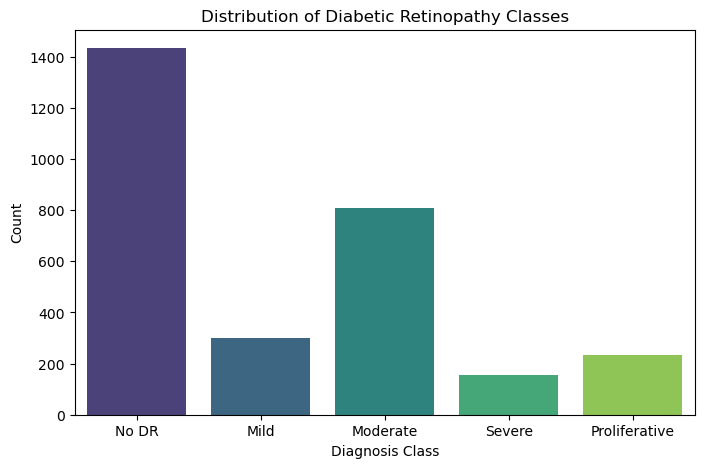

In [2]:
# Diabetic Retinopathy EDA Notebook
# Author: Murli Satagopan
# Capstone Module 23

# 📦 Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# ## 🧭 Step 1: Load Dataset
# Load the CSV file containing image IDs and diagnosis labels
df = pd.read_csv('.\\Data\\train_1.csv')  # Update path if needed

# ## 🔍 Step 2: Initial Inspection
print("Shape of dataset:", df.shape)
print("Columns:", df.columns)
print("Sample rows:")
print(df.head())

# ## 🧼 Step 3: Check for Missing Values
print("\nMissing values:")
print(df.isnull().sum())

# ## 📊 Step 4: Class Distribution
plt.figure(figsize=(8,5))
sns.countplot(x='diagnosis', data=df, palette='viridis')
plt.title('Distribution of Diabetic Retinopathy Classes')
plt.xlabel('Diagnosis Class')
plt.ylabel('Count')
plt.xticks(ticks=[0,1,2,3,4], labels=['No DR','Mild','Moderate','Severe','Proliferative'])
plt.show()


#### Step 2 Image size and quality check. Plot the distribution of image dimensions

Sample image size: (3216, 2136)


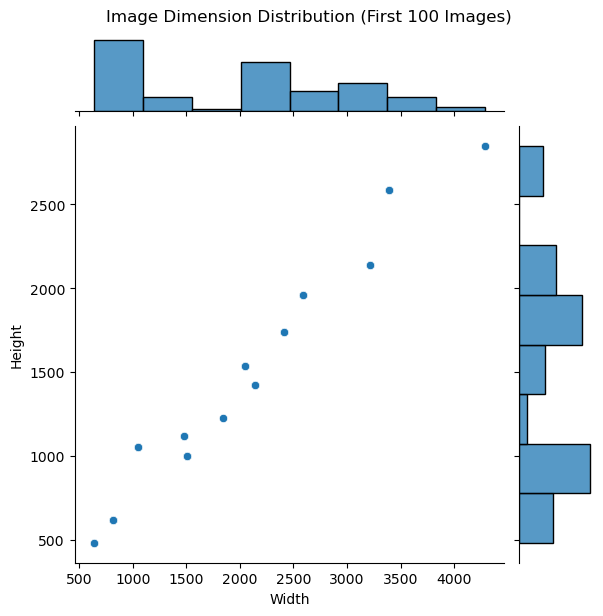

In [3]:
# ## 📷 Step 5: Image Size & Quality Check
image_dir = 'data\\train_images\\train_images'
sample_image = Image.open(os.path.join(image_dir, df['id_code'][0] + '.png'))
print("Sample image size:", sample_image.size)
sample_image.show()

# ## 📐 Step 6: Image Dimension Distribution
dims = []
for img_id in df['id_code'][:100]:  # Limit to first 100 for speed
    try:
        img = Image.open(os.path.join(image_dir, img_id + '.png'))
        dims.append(img.size)
    except:
        continue

dims_df = pd.DataFrame(dims, columns=['Width', 'Height'])
sns.jointplot(data=dims_df, x='Width', y='Height', kind='scatter')
plt.suptitle('Image Dimension Distribution (First 100 Images)', y=1.02)
plt.show()



#### Image Preprocessing. Resize images to a consistent shape (in this case 224x224 for a Resnet 50 model)

## Image Preprocessing
- Resize images to a consistent shape (224x224)
- Normalize pixel values
- Apply histogram equalization or CLAHE for contrast enhancement
- Save preprocessed images for reuse

In [7]:
# Image Preprocessing - Resize, Normalize, CLAHE, Save
import cv2
from PIL import Image
import os

def preprocess_image(img_path, output_path):
    # Load image and convert to RGB
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))
    img_np = np.array(img)
    # Normalize pixel values to [0, 255] for CLAHE
    img_lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    img_lab = cv2.merge((cl, a, b))
    img_clahe = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    # Normalize pixel values to [0,1]
    img_norm = img_clahe / 255.0
    # Convert back to PIL Image for saving
    img_out = Image.fromarray((img_norm * 255).astype(np.uint8))
    img_out.save(output_path)

## Preprocess images in training set.
input_dir = 'data/train_images/train_images'
output_dir = 'data/train_images/resimages'
os.makedirs(output_dir, exist_ok=True)

# Loop over all images in input_dir
for fname in os.listdir(input_dir):
    if fname.lower().endswith('.png') or fname.lower().endswith('.jpg'):
        in_path = os.path.join(input_dir, fname)
        out_path = os.path.join(output_dir, fname)
        preprocess_image(in_path, out_path)

## Preprocess images in test set.
input_dir = 'data/test_images/test_images'
output_dir = 'data/test_images/resimages'
os.makedirs(output_dir, exist_ok=True)

# Loop over all images in input_dir
for fname in os.listdir(input_dir):
    if fname.lower().endswith('.png') or fname.lower().endswith('.jpg'):
        in_path = os.path.join(input_dir, fname)
        out_path = os.path.join(output_dir, fname)
        preprocess_image(in_path, out_path)

## Preprocess images in validation set.
input_dir = 'data/val_images/val_images'
output_dir = 'data/val_images/resimages'
os.makedirs(output_dir, exist_ok=True)

# Loop over all images in input_dir
for fname in os.listdir(input_dir):
    if fname.lower().endswith('.png') or fname.lower().endswith('.jpg'):
        in_path = os.path.join(input_dir, fname)
        out_path = os.path.join(output_dir, fname)
        preprocess_image(in_path, out_path)


## Feature Engineering and baseline model
- Build a "Classical Extractor" that Extracts color histograms, texture metrics, and edge maps
- Try logistic regression, and decision trees
- Evaluate using accuracy, precision, recall, and F1-score

In [17]:
# Feature Engineering and Baseline Model (using pre-resized images)
import cv2
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import os

def extract_features(img_path):
    img = cv2.imread(img_path)
    # Color histogram (flattened)
    hist = cv2.calcHist([img], [0, 1, 2], None, [8,8,8], [0,256,0,256,0,256]).flatten()
    # Texture metric: mean and std of grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mean = np.mean(gray)
    std = np.std(gray)
    # Edge map: sum of edges
    edges = cv2.Canny(gray, 100, 200)
    edge_sum = np.sum(edges)
    return np.concatenate([hist, [mean, std, edge_sum]])

# Load train, test, val sets
train_csv = '.\\Data\\train_1.csv'
test_csv = '.\\Data\\test.csv'
val_csv = '.\\Data\\valid.csv'
train_img_dir = 'data/train_images/resimages'
test_img_dir = 'data/test_images/resimages'
val_img_dir = 'data/val_images/resimages'

# Training set
train_df = pd.read_csv(train_csv)
X_train, y_train = [], []
for idx, row in train_df.iterrows():
    img_path = os.path.join(train_img_dir, row['id_code'] + '.png')
    if os.path.exists(img_path):
        X_train.append(extract_features(img_path))
        y_train.append(row['diagnosis'])
X_train = np.array(X_train)
y_train = np.array(y_train)

# Test set
test_df = pd.read_csv(test_csv)
X_test, y_test = [], []
for idx, row in test_df.iterrows():
    img_path = os.path.join(test_img_dir, row['id_code'] + '.png')
    if os.path.exists(img_path):
        X_test.append(extract_features(img_path))
        y_test.append(row['diagnosis'])
X_test = np.array(X_test)
y_test = np.array(y_test)

# Validation set (optional)
val_df = pd.read_csv(val_csv)
X_val, y_val = [], []
for idx, row in val_df.iterrows():
    img_path = os.path.join(val_img_dir, row['id_code'] + '.png')
    if os.path.exists(img_path):
        X_val.append(extract_features(img_path))
        y_val.append(row['diagnosis'])
X_val = np.array(X_val)
y_val = np.array(y_val)

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val) if len(X_val) > 0 else None

# Logistic Regression
lr = LogisticRegression(max_iter=300)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print('Logistic Regression Performance (Test):')
print(classification_report(y_test, y_pred_lr))

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)
print('Decision Tree Performance (Test):')
print(classification_report(y_test, y_pred_dt))

# Optionally evaluate on validation set
if len(X_val) > 0:
    y_pred_val_lr = lr.predict(X_val_scaled)
    print('Logistic Regression Performance (Validation):')
    print(classification_report(y_val, y_pred_val_lr))
    y_pred_val_dt = dt.predict(X_val_scaled)
    print('Decision Tree Performance (Validation):')
    print(classification_report(y_val, y_pred_val_dt))

Logistic Regression Performance (Test):
              precision    recall  f1-score   support

           0       0.92      0.85      0.89       199
           1       0.13      0.07      0.09        30
           2       0.46      0.75      0.57        87
           3       0.36      0.24      0.29        17
           4       0.25      0.12      0.16        33

    accuracy                           0.67       366
   macro avg       0.43      0.40      0.40       366
weighted avg       0.66      0.67      0.65       366

Decision Tree Performance (Test):
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       199
           1       0.27      0.27      0.27        30
           2       0.56      0.61      0.58        87
           3       0.18      0.18      0.18        17
           4       0.37      0.33      0.35        33

    accuracy                           0.70       366
   macro avg       0.46      0.46      0.46       366
wei

In [18]:
# Utility function for detailed metrics for each class: No DR, Mild, Moderate, Severe, Proliferative
from sklearn.metrics import precision_score, recall_score, accuracy_score
import numpy as np

class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']

def print_class_metrics(y_true, y_pred, model_name):
    print(f"\nMetrics for {model_name}:")
    for i, class_name in enumerate(class_names):
        y_true_bin = (y_true == i).astype(int)
        y_pred_bin = (y_pred == i).astype(int)
        prec = precision_score(y_true_bin, y_pred_bin, zero_division=0)
        rec = recall_score(y_true_bin, y_pred_bin, zero_division=0)
        acc = accuracy_score(y_true_bin, y_pred_bin)
        print(f"Class '{class_name}': Precision={prec:.3f}, Recall={rec:.3f}, Accuracy={acc:.3f}")
    dr_mask = (y_true != 0)
    missed_dr = np.sum((y_pred[dr_mask] == 0))
    total_dr = np.sum(dr_mask)
    print(f"\nNumber of DR cases misclassified as 'No DR': {missed_dr} out of {total_dr} DR cases")

In [19]:
# Metrics for Logistic Regression (classical features)
print_class_metrics(y_test, y_pred_lr, "Logistic Regression (Classical Features)")

# Metrics for Decision Tree (classical features)
print_class_metrics(y_test, y_pred_dt, "Decision Tree (Classical Features)")


Metrics for Logistic Regression (Classical Features):
Class 'No DR': Precision=0.924, Recall=0.854, Accuracy=0.883
Class 'Mild': Precision=0.133, Recall=0.067, Accuracy=0.888
Class 'Moderate': Precision=0.464, Recall=0.747, Accuracy=0.735
Class 'Severe': Precision=0.364, Recall=0.235, Accuracy=0.945
Class 'Proliferative': Precision=0.250, Recall=0.121, Accuracy=0.888

Number of DR cases misclassified as 'No DR': 14 out of 167 DR cases

Metrics for Decision Tree (Classical Features):
Class 'No DR': Precision=0.943, Recall=0.920, Accuracy=0.926
Class 'Mild': Precision=0.267, Recall=0.267, Accuracy=0.880
Class 'Moderate': Precision=0.558, Recall=0.609, Accuracy=0.792
Class 'Severe': Precision=0.176, Recall=0.176, Accuracy=0.923
Class 'Proliferative': Precision=0.367, Recall=0.333, Accuracy=0.888

Number of DR cases misclassified as 'No DR': 11 out of 167 DR cases


## Step 11: Visualization & Insights
- Use PCA or t-SNE to visualize feature space
- Plot confusion matrix to understand misclassifications
- Identify class imbalance and consider resampling techniques

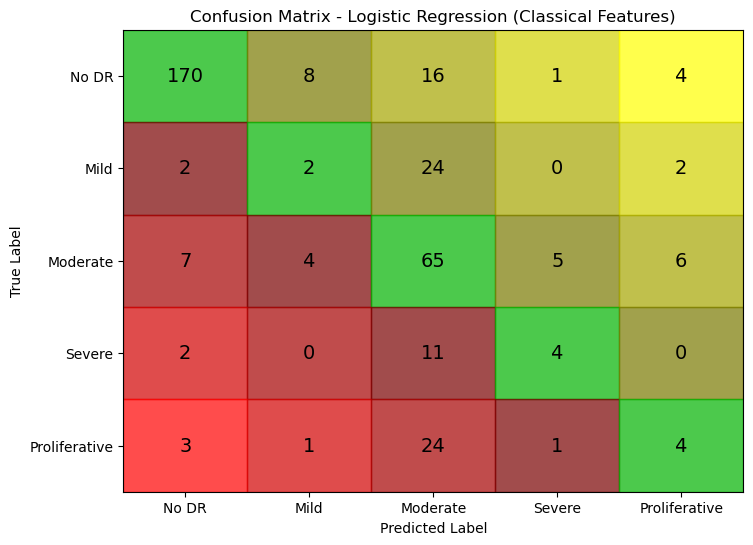

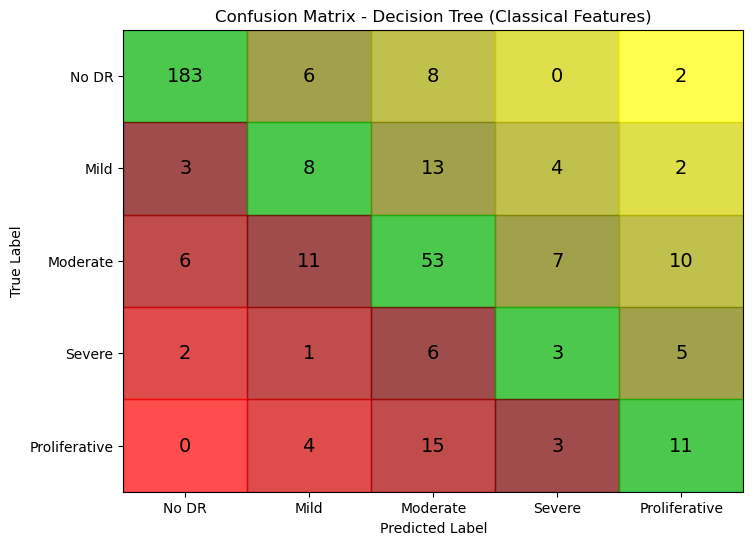

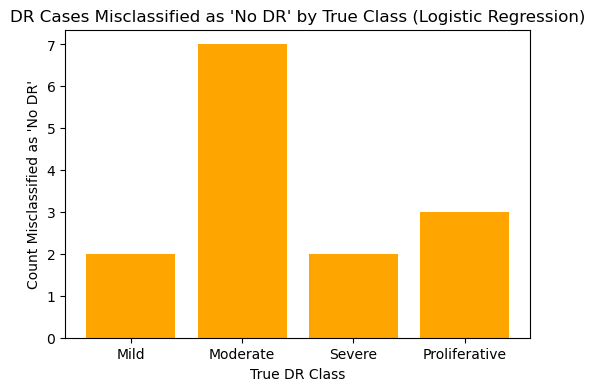

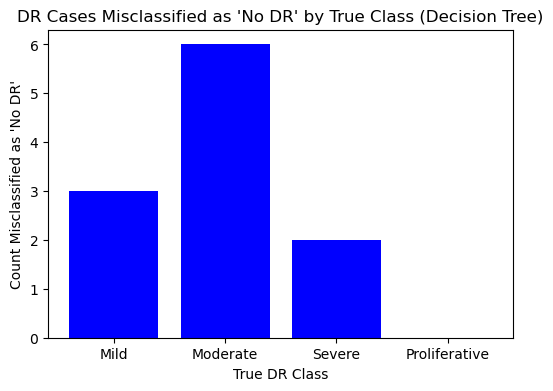

In [27]:
# Enhanced confusion matrix heatmap for classical features with degree of misdiagnosis shading
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def misdiagnosis_color(i, j, n_classes):
    # Green for correct
    if i == j:
        return (0.0, 0.7, 0.0)  # green
    # Red shades for under-diagnosis (predicted less severe than true)
    elif j < i:
        # Severity: difference between true and predicted
        diff = i - j
        intensity = 0.3 + 0.7 * (diff / (n_classes-1))
        return (intensity, 0.0, 0.0)  # red, darker for more severe missed
    # Yellow shades for over-diagnosis (predicted more severe than true)
    elif j > i:
        diff = j - i
        intensity = 0.3 + 0.7 * (diff / (n_classes-1))
        return (intensity, intensity, 0.0)  # yellow, darker for more severe false positive
    # Should not occur, but fallback to white
    else:
        return (1.0, 1.0, 1.0)

def plot_enhanced_confusion_matrix(cm, title, class_names):
    n_classes = len(class_names)
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = misdiagnosis_color(i, j, n_classes)
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, alpha=0.7))
            ax.text(j+0.5, i+0.5, cm[i, j], ha='center', va='center', fontsize=14)
    ax.set_xticks(np.arange(n_classes)+0.5)
    ax.set_yticks(np.arange(n_classes)+0.5)
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(title)
    ax.set_xlim(0, n_classes)
    ax.set_ylim(0, n_classes)
    plt.gca().invert_yaxis()
    plt.show()

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plot_enhanced_confusion_matrix(cm_lr, 'Confusion Matrix - Logistic Regression (Classical Features)', class_names)

# Decision Tree Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
plot_enhanced_confusion_matrix(cm_dt, 'Confusion Matrix - Decision Tree (Classical Features)', class_names)

# Bar chart: DR cases misclassified as 'No DR' by true class for Logistic Regression
dr_classes = [1, 2, 3, 4]
misclassified_counts_lr = []
for i in dr_classes:
    true_mask = (y_test == i)
    misclassified = np.sum((y_pred_lr[true_mask] == 0))
    misclassified_counts_lr.append(misclassified)

plt.figure(figsize=(6,4))
plt.bar([class_names[i] for i in dr_classes], misclassified_counts_lr, color='orange')
plt.title("DR Cases Misclassified as 'No DR' by True Class (Logistic Regression)")
plt.xlabel("True DR Class")
plt.ylabel("Count Misclassified as 'No DR'")
plt.show()

# Bar chart: DR cases misclassified as 'No DR' by true class for Decision Tree
misclassified_counts_dt = []
for i in dr_classes:
    true_mask = (y_test == i)
    misclassified = np.sum((y_pred_dt[true_mask] == 0))
    misclassified_counts_dt.append(misclassified)

plt.figure(figsize=(6,4))
plt.bar([class_names[i] for i in dr_classes], misclassified_counts_dt, color='blue')
plt.title("DR Cases Misclassified as 'No DR' by True Class (Decision Tree)")
plt.xlabel("True DR Class")
plt.ylabel("Count Misclassified as 'No DR'")
plt.show()

## Advanced Modeling: Feature Extraction with Pre-trained ResNet50

In [30]:
# Advanced Modeling: Feature Extraction with Pre-trained ResNet50
import numpy as np
import pandas as pd
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Load pre-trained ResNet50 model (without top layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_resnet_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = resnet_model.predict(x)
    return features.flatten()

# Training set
train_csv = '.\\Data\\train_1.csv'
train_img_dir = 'data/train_images/resimages'
train_df = pd.read_csv(train_csv)
X_train, y_train = [], []
for idx, row in train_df.iterrows():
    img_path = os.path.join(train_img_dir, row['id_code'] + '.png')
    if os.path.exists(img_path):
        X_train.append(extract_resnet_features(img_path))
        y_train.append(row['diagnosis'])
X_train = np.array(X_train)
y_train = np.array(y_train)

# Test set
test_csv = '.\\Data\\test.csv'
test_img_dir = 'data/test_images/resimages'
test_df = pd.read_csv(test_csv)
X_test, y_test = [], []
for idx, row in test_df.iterrows():
    img_path = os.path.join(test_img_dir, row['id_code'] + '.png')
    if os.path.exists(img_path):
        X_test.append(extract_resnet_features(img_path))
        y_test.append(row['diagnosis'])
X_test = np.array(X_test)
y_test = np.array(y_test)

# Scale ResNet50 features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a logistic regression classifier on ResNet50 features
lr = LogisticRegression(max_iter=300)
lr.fit(X_train_scaled, y_train)
y_pred_lr_cnn = lr.predict(X_test_scaled)
print('Logistic Regression on ResNet50 Features (Test):')
print(classification_report(y_test, y_pred_lr_cnn))

# Train a decision tree classifier on ResNet50 features
dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)
y_pred_dt_cnn = dt.predict(X_test_scaled)
print('Decision Tree on ResNet50 Features (Test):')
print(classification_report(y_test, y_pred_dt_cnn))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107

### Summary of Findings

In [31]:
# Detailed metrics for each class: No DR, Mild, Moderate, Severe, Proliferative (CNN Features)
# Reuse print_class_metrics from previous block
print_class_metrics(y_test, y_pred_lr_cnn, "Logistic Regression (CNN Features)")
print_class_metrics(y_test, y_pred_dt_cnn, "Decision Tree (CNN Features)")


Metrics for Logistic Regression (CNN Features):
Class 'No DR': Precision=0.970, Recall=0.975, Accuracy=0.970
Class 'Mild': Precision=0.515, Recall=0.567, Accuracy=0.921
Class 'Moderate': Precision=0.667, Recall=0.759, Accuracy=0.852
Class 'Severe': Precision=0.231, Recall=0.176, Accuracy=0.934
Class 'Proliferative': Precision=0.524, Recall=0.333, Accuracy=0.913

Number of DR cases misclassified as 'No DR': 6 out of 167 DR cases

Metrics for Decision Tree (CNN Features):
Class 'No DR': Precision=0.925, Recall=0.925, Accuracy=0.918
Class 'Mild': Precision=0.375, Recall=0.400, Accuracy=0.896
Class 'Moderate': Precision=0.596, Recall=0.678, Accuracy=0.814
Class 'Severe': Precision=0.231, Recall=0.176, Accuracy=0.934
Class 'Proliferative': Precision=0.391, Recall=0.273, Accuracy=0.896

Number of DR cases misclassified as 'No DR': 15 out of 167 DR cases


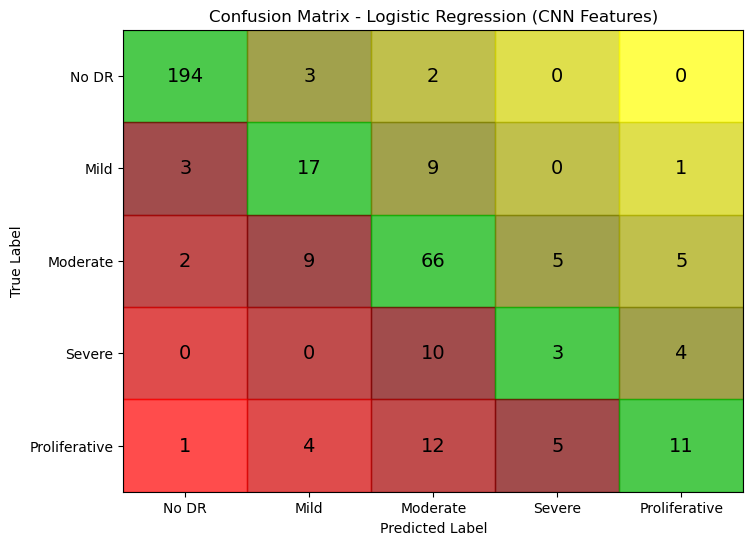

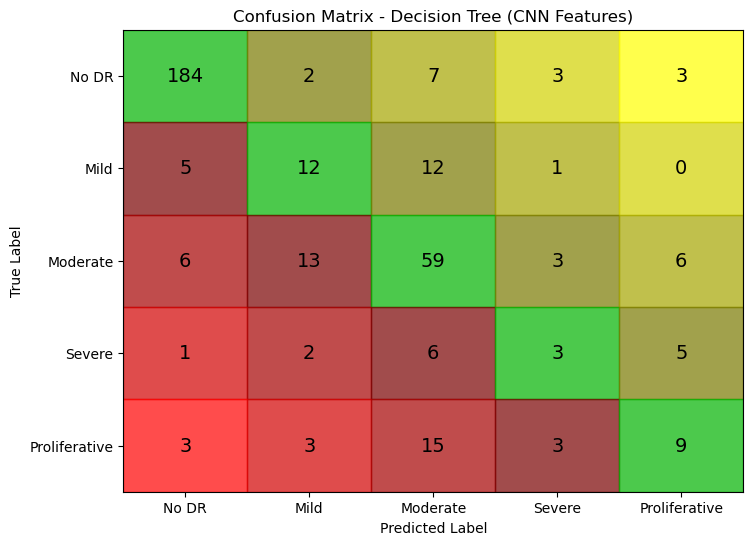

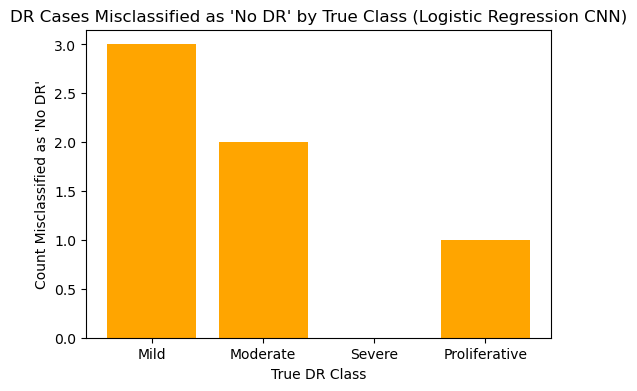

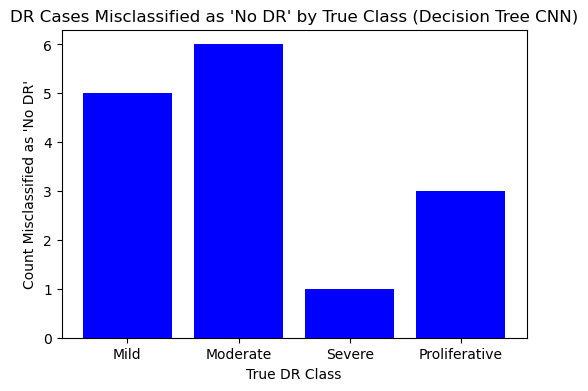

In [32]:
# Enhanced confusion matrix heatmap for CNN features with degree of misdiagnosis shading
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Logistic Regression Confusion Matrix (CNN features)
cm_lr_cnn = confusion_matrix(y_test, y_pred_lr_cnn)
plot_enhanced_confusion_matrix(cm_lr_cnn, 'Confusion Matrix - Logistic Regression (CNN Features)', class_names)

# Decision Tree Confusion Matrix (CNN features)
cm_dt_cnn = confusion_matrix(y_test, y_pred_dt_cnn)
plot_enhanced_confusion_matrix(cm_dt_cnn, 'Confusion Matrix - Decision Tree (CNN Features)', class_names)

# Bar chart: DR cases misclassified as 'No DR' by true class for Logistic Regression (CNN features)
dr_classes = [1, 2, 3, 4]
misclassified_counts_lr_cnn = []
for i in dr_classes:
    true_mask = (y_test == i)
    misclassified = np.sum((y_pred_lr_cnn[true_mask] == 0))
    misclassified_counts_lr_cnn.append(misclassified)

plt.figure(figsize=(6,4))
plt.bar([class_names[i] for i in dr_classes], misclassified_counts_lr_cnn, color='orange')
plt.title("DR Cases Misclassified as 'No DR' by True Class (Logistic Regression CNN)")
plt.xlabel("True DR Class")
plt.ylabel("Count Misclassified as 'No DR'")
plt.show()

# Bar chart: DR cases misclassified as 'No DR' by true class for Decision Tree (CNN features)
misclassified_counts_dt_cnn = []
for i in dr_classes:
    true_mask = (y_test == i)
    misclassified = np.sum((y_pred_dt_cnn[true_mask] == 0))
    misclassified_counts_dt_cnn.append(misclassified)

plt.figure(figsize=(6,4))
plt.bar([class_names[i] for i in dr_classes], misclassified_counts_dt_cnn, color='blue')
plt.title("DR Cases Misclassified as 'No DR' by True Class (Decision Tree CNN)")
plt.xlabel("True DR Class")
plt.ylabel("Count Misclassified as 'No DR'")
plt.show()

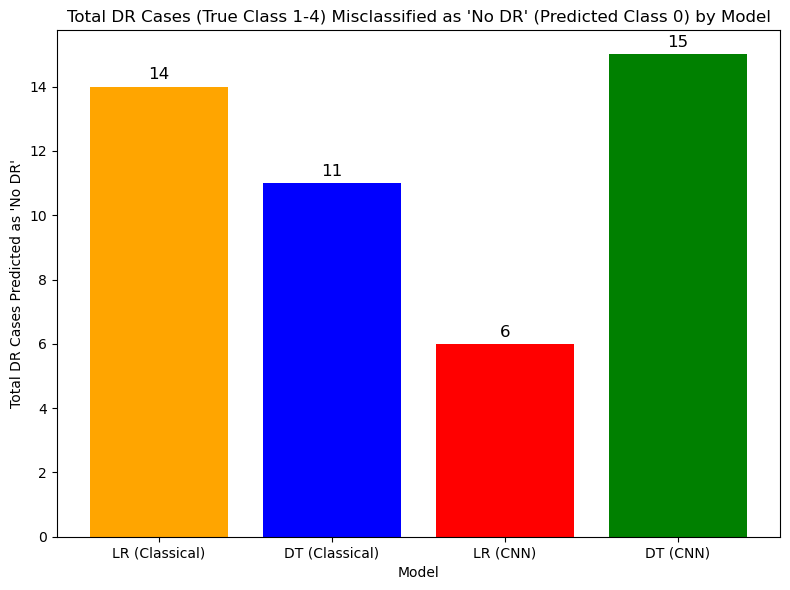

In [37]:
# --- Bar chart: Total DR cases (true class 1-4) misclassified as 'No DR' (predicted class 0) ---
dr_classes = [1, 2, 3, 4]
total_misclassified_lr = np.sum([np.sum((y_pred_lr[y_test == i] == 0)) for i in dr_classes])
total_misclassified_dt = np.sum([np.sum((y_pred_dt[y_test == i] == 0)) for i in dr_classes])
total_misclassified_lr_cnn = np.sum([np.sum((y_pred_lr_cnn[y_test == i] == 0)) for i in dr_classes])
total_misclassified_dt_cnn = np.sum([np.sum((y_pred_dt_cnn[y_test == i] == 0)) for i in dr_classes])

models = ['LR (Classical)', 'DT (Classical)', 'LR (CNN)', 'DT (CNN)']
counts = [total_misclassified_lr, total_misclassified_dt, total_misclassified_lr_cnn, total_misclassified_dt_cnn]
colors = ['orange', 'blue', 'red', 'green']

fig, ax = plt.subplots(figsize=(8,6))
bars = ax.bar(models, counts, color=colors)
ax.set_xlabel('Model')
ax.set_ylabel("Total DR Cases Predicted as 'No DR'")
ax.set_title("Total DR Cases (True Class 1-4) Misclassified as 'No DR' (Predicted Class 0) by Model")

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

## Conclusion: Exploratory Data Analysis and Modeling Summary
- The dataset was pre-split into training, test, and validation sets, ensuring robust evaluation and preventing data leakage.
- No missing values were found in the data, allowing for straightforward analysis and modeling.
- We examined the distribution of diabetic retinopathy (DR) cases and observed significant class imbalance, with the majority of samples labeled as 'No DR' and fewer cases in the more severe categories.
- Image dimension analysis showed variability, so all images were resized to a standard 224x224 pixels to enable consistent feature extraction and compatibility with deep learning models.
- Classical feature extraction was performed using color histograms, texture metrics, and edge maps. This approach was chosen to provide interpretable, lower-dimensional features for baseline models and to capture clinically relevant image characteristics.
- Classical models (logistic regression and decision tree) were trained on these features. Both models showed reasonable performance, but misclassification of DR cases as 'No DR' was a notable issue, especially for the decision tree.
- To improve feature representation, we used a pre-trained ResNet50 CNN to extract deep features from the images. These embeddings capture more complex patterns and subtle differences between classes.
- Logistic regression performed well on the CNN features, significantly reducing the number of DR cases misclassified as 'No DR'. Decision tree performance, however, declined with CNN features due to overfitting and the high dimensionality of the embeddings.
- Overall, logistic regression with CNN-based features provided the best balance, minimizing clinically critical misclassifications and demonstrating the value of deep feature extraction for this task.